# Moderation Analysis

In [128]:
# Import necessary libraries
import pandas as pd
import ast
import json
import matplotlib.pyplot as plt
from collections import Counter
import re

### Loading and Examining Data Structure

In [129]:
# Load the cleaned dataset
reddit_df = pd.read_csv('./data/combined_cleaned_500k.csv', lineterminator='\n', encoding='utf8')

reddit_df['moderation'] = reddit_df['moderation\r'].apply(ast.literal_eval)

### Check Data Structure

In [130]:
# See full content of each entry
pd.set_option('display.max_colwidth', None)

# Check the total number of rows in the dataset
total_rows = reddit_df.shape[0]
print(f"Total number of rows: {total_rows}")

# Check if there are any null values in the 'moderation' column
null_moderation_count = reddit_df['moderation'].isnull().sum()
print(f"Number of rows with null moderation: {null_moderation_count}")

Total number of rows: 396298
Number of rows with null moderation: 0


### Understanding the Moderation Keys

In [131]:
# Get all unique keys in the moderation column
all_keys = set().union(*(d.keys() for d in reddit_df['moderation']))

# Print unique keys
print("Unique keys in moderation:", all_keys)

# Function to handle non-list and list values separately
def get_unique_values(key):
    # Check if the value is a list or not
    if reddit_df['moderation'].apply(lambda x: isinstance(x.get(key), list)).any():
        # For lists, flatten them and get unique elements
        all_list_values = [item for sublist in reddit_df['moderation'].apply(lambda x: x.get(key)).dropna() for item in sublist]
        return set(all_list_values)
    else:
        # For non-list values, just return the unique values
        return reddit_df['moderation'].apply(lambda x: x.get(key)).unique()

# Loop through all keys and print their unique values
for key in all_keys:
    unique_values = get_unique_values(key)
    print(f"Unique values for {key}: {unique_values}")
    
# Check the first few entries of the moderation column
print(reddit_df['moderation'].head(10))

Unique keys in moderation: {'collapsed', 'collapsed_reason', 'user_reports', 'banned_at_utc', 'num_reports', 'collapsed_reason_code', 'removal_reason', 'mod_reason_by', 'mod_reason_title', 'mod_note', 'report_reasons', 'controversiality', 'author_is_blocked', 'banned_by', 'mod_reports'}
Unique values for collapsed: [False  True]
Unique values for collapsed_reason: [None 'comment score below threshold']
Unique values for user_reports: set()
Unique values for banned_at_utc: [None]
Unique values for num_reports: [nan  0.]
Unique values for collapsed_reason_code: [None 'LOW_SCORE' 'DELETED']
Unique values for removal_reason: [None 'legal']
Unique values for mod_reason_by: [None]
Unique values for mod_reason_title: [None]
Unique values for mod_note: [None]
Unique values for report_reasons: set()
Unique values for controversiality: [0 1]
Unique values for author_is_blocked: [None False]
Unique values for banned_by: [None]
Unique values for mod_reports: set()
0           {'removal_reason': No

### Flagging Different Types of Moderation Actions

#### Creating Flags for Key Moderation Action + Seeing Their Distribution

In [132]:
# Create boolean flags for collapsed, deleted, low-score, removed, and controversial comments
reddit_df['is_collapsed'] = reddit_df['moderation'].apply(lambda x: x.get('collapsed') == True)
reddit_df['is_deleted'] = reddit_df['moderation'].apply(lambda x: x.get('collapsed_reason_code') == 'DELETED')
reddit_df['is_low_score'] = reddit_df['moderation'].apply(lambda x: x.get('collapsed_reason_code') == 'LOW_SCORE')
reddit_df['is_removed'] = reddit_df['moderation'].apply(lambda x: x.get('removal_reason') is not None)
reddit_df['is_controversial'] = reddit_df['moderation'].apply(lambda x: x.get('controversiality') == 1)

# Print counts for each flag to verify
print(f"Collapsed comments: {reddit_df['is_collapsed'].sum()}")
print(f"Deleted comments: {reddit_df['is_deleted'].sum()}")
print(f"Low-score comments: {reddit_df['is_low_score'].sum()}")
print(f"Removed comments: {reddit_df['is_removed'].sum()}")
print(f"Controversial comments: {reddit_df['is_controversial'].sum()}")

Collapsed comments: 15696
Deleted comments: 576
Low-score comments: 8228
Removed comments: 8
Controversial comments: 15373


### Investigating the Relationships Between the Moderation Actions-- Collapsing & Deleting Comments

#### Collapsed Comments with Reason Codes 

##### We begin by checking collapsed comments that have a collapsed_reason_code. This helps us investigate why some comments were collapsed (e.g., low score or other reasons).

In [133]:
# Investigate collapsed comments with reason codes
collapsed_with_reason_code_df = reddit_df[(reddit_df['is_collapsed']) & (reddit_df['moderation'].apply(lambda x: x.get('collapsed_reason_code') is not None))]
print("Collapsed comments with reason codes:")
print(collapsed_with_reason_code_df['moderation'].head(10))

Collapsed comments with reason codes:
128                                {'collapsed_reason_code': 'LOW_SCORE', 'collapsed_reason': 'comment score below threshold', 'collapsed': True, 'controversiality': 0}
182                                {'collapsed_reason_code': 'LOW_SCORE', 'collapsed_reason': 'comment score below threshold', 'collapsed': True, 'controversiality': 0}
419                                {'collapsed_reason_code': 'LOW_SCORE', 'collapsed_reason': 'comment score below threshold', 'collapsed': True, 'controversiality': 0}
429    {'collapsed_reason': 'comment score below threshold', 'author_is_blocked': False, 'collapsed_reason_code': 'LOW_SCORE', 'collapsed': True, 'controversiality': 0}
430                                {'collapsed_reason_code': 'LOW_SCORE', 'collapsed_reason': 'comment score below threshold', 'collapsed': True, 'controversiality': 1}
437    {'collapsed_reason': 'comment score below threshold', 'author_is_blocked': False, 'collapsed_reason_code': 'LO

#### Collapsed but Not Low-Score Comments

##### We then check collapsed comments that are not flagged as low score to explore other potential reasons for collapse.

In [134]:
# Check for collapsed comments that are NOT low-score
collapsed_not_low_score_df = reddit_df[(reddit_df['is_collapsed']) & (~reddit_df['is_low_score'])]

In [135]:
# Check unique collapsed_reason_code values for these comments
collapsed_not_low_score_reasons = collapsed_not_low_score_df['moderation'].apply(lambda x: x.get('collapsed_reason_code')).unique()
print(f"Unique collapsed_reason_code for collapsed but not low-score comments: {collapsed_not_low_score_reasons}")

Unique collapsed_reason_code for collapsed but not low-score comments: [None 'DELETED']


#### Collapsed but Not Deleted Comments

##### Next, we focus on collapsed comments that were not deleted. This helps us see if there’s a significant relationship between collapsing and deleting actions.

In [136]:
# Check for collapsed comments that were NOT deleted
collapsed_not_deleted_df = reddit_df[(reddit_df['is_collapsed']) & (~reddit_df['is_deleted'])]

# Check unique collapsed_reason_code values for these comments
collapsed_not_deleted_reasons = collapsed_not_deleted_df['moderation'].apply(lambda x: x.get('collapsed_reason_code')).unique()
print(f"Unique collapsed_reason_code for collapsed but not deleted comments: {collapsed_not_deleted_reasons}")

# Investigate overlap between collapsed and deleted comments
collapsed_deleted_overlap_df = reddit_df[(reddit_df['is_collapsed']) & (reddit_df['is_deleted'])]
collapsed_not_deleted_df = reddit_df[(reddit_df['is_collapsed']) & (~reddit_df['is_deleted'])]

Unique collapsed_reason_code for collapsed but not deleted comments: [None 'LOW_SCORE']


#### Analyzing the Proportions of Collapsed vs. Deleted Comments

##### We calculate the proportion of collapsed comments that are deleted versus those that are not. This gives insight into how often collapsed comments are further moderated (deleted) and allows us to investigate potential patterns.

In [137]:
# Calculate proportion of collapsed comments that are deleted or not deleted
collapsed_deleted_overlap_percentage = len(collapsed_deleted_overlap_df) / reddit_df['is_collapsed'].sum()
collapsed_not_deleted_percentage = len(collapsed_not_deleted_df) / reddit_df['is_collapsed'].sum()

print(f"Percentage of collapsed comments that are deleted: {collapsed_deleted_overlap_percentage:.2%}")
print(f"Percentage of collapsed comments that are NOT deleted: {collapsed_not_deleted_percentage:.2%}")

# Investigate collapsed but not deleted comments
collapsed_not_deleted_df = reddit_df[(reddit_df['is_collapsed']) & (~reddit_df['is_deleted'])]

# Get a sample of these comments to understand them
print(collapsed_not_deleted_df[['moderation', 'text']].head(10))

Percentage of collapsed comments that are deleted: 3.67%
Percentage of collapsed comments that are NOT deleted: 96.33%
                                                                                                                                moderation  \
105                {'removal_reason': None, 'collapsed': True, 'collapsed_reason': 'comment score below threshold', 'controversiality': 0}   
107                {'removal_reason': None, 'collapsed': True, 'collapsed_reason': 'comment score below threshold', 'controversiality': 0}   
128  {'collapsed_reason_code': 'LOW_SCORE', 'collapsed_reason': 'comment score below threshold', 'collapsed': True, 'controversiality': 0}   
148                {'removal_reason': None, 'collapsed': True, 'collapsed_reason': 'comment score below threshold', 'controversiality': 0}   
182  {'collapsed_reason_code': 'LOW_SCORE', 'collapsed_reason': 'comment score below threshold', 'collapsed': True, 'controversiality': 0}   
184                {'removal_

#### Analyze Patterns in Collapsed Comments with No Reason

##### We found that a large proportion of collapsed comments do not have an apparent `collapsed_reason_code`. To gain insights, we further investigate whether these comments tend to be controversial and explore their text content. Additionally, we group these comments by subreddit to identify if certain subreddits exhibit more collapses without a reason.

In [138]:
# Check the unique collapsed_reason_code values
unique_reasons = collapsed_not_deleted_df['moderation'].apply(lambda x: x.get('collapsed_reason_code')).unique()
print(f"Unique collapsed_reason_code for collapsed but not deleted: {unique_reasons}")

# Explore collapsed comments with no reason
collapsed_no_reason_df = reddit_df[(reddit_df['is_collapsed']) & (reddit_df['moderation'].apply(lambda x: x.get('collapsed_reason_code') is None))]

# Investigate controversiality in collapsed comments without a reason
controversial_collapsed_no_reason = collapsed_no_reason_df[collapsed_no_reason_df['is_controversial']]
print(f"Number of controversial collapsed comments with no reason: {len(controversial_collapsed_no_reason)}")

# Analyze the text of collapsed comments with no reason
print(collapsed_no_reason_df[['moderation', 'text']].head(10))

# Group by subreddit to see if certain subreddits have more collapsed comments with no reason
collapsed_no_reason_subreddit = collapsed_no_reason_df.groupby('subreddit_id').size().sort_values(ascending=False)
print("Collapsed comments with no reason by subreddit:")
print(collapsed_no_reason_subreddit.head(10))

Unique collapsed_reason_code for collapsed but not deleted: [None 'LOW_SCORE']
Number of controversial collapsed comments with no reason: 484
                                                                                                                  moderation  \
105  {'removal_reason': None, 'collapsed': True, 'collapsed_reason': 'comment score below threshold', 'controversiality': 0}   
107  {'removal_reason': None, 'collapsed': True, 'collapsed_reason': 'comment score below threshold', 'controversiality': 0}   
148  {'removal_reason': None, 'collapsed': True, 'collapsed_reason': 'comment score below threshold', 'controversiality': 0}   
184  {'removal_reason': None, 'collapsed': True, 'collapsed_reason': 'comment score below threshold', 'controversiality': 0}   
273  {'removal_reason': None, 'collapsed': True, 'collapsed_reason': 'comment score below threshold', 'controversiality': 0}   
281  {'removal_reason': None, 'collapsed': True, 'collapsed_reason': 'comment score below 

#### Common Themes in Collapsed Comments

##### To further understand what kinds of content tend to be moderated, we analyze the most common words found in collapsed comments. By filtering out common stopwords and focusing on frequently used terms, we can identify potential reasons why comments are collapsed (e.g., inflammatory language, controversial topics, etc.)

In [139]:
# Combine all text from collapsed comments
collapsed_texts = " ".join(collapsed_no_reason_df['text'].fillna("")).lower()

# Extract word frequencies from collapsed comments' text (removing common stopwords)
word_pattern = r'\b\w+\b'
collapsed_words = re.findall(word_pattern, collapsed_texts)

# Count word frequency
word_counts = Counter(collapsed_words)

# Print the most common words
print("Most common words in collapsed comments:")
print(word_counts.most_common(20))

Most common words in collapsed comments:
[('the', 8242), ('to', 6372), ('and', 4169), ('a', 4029), ('is', 3510), ('of', 3446), ('i', 2995), ('you', 2808), ('in', 2680), ('that', 2631), ('for', 2244), ('it', 2193), ('are', 1874), ('not', 1820), ('be', 1596), ('this', 1488), ('have', 1443), ('they', 1399), ('if', 1291), ('but', 1247)]


### VISUALISATION 1: MODERATION ACROSS TIME

#### Time-Series Analysis of Moderation Trends

##### Here, we plot moderation trends over time, tracking the proportion of collapsed, deleted, and controversial comments by month. This allows us to identify periods with significant moderation activity, and we investigate further by filtering and inspecting comments from that period.

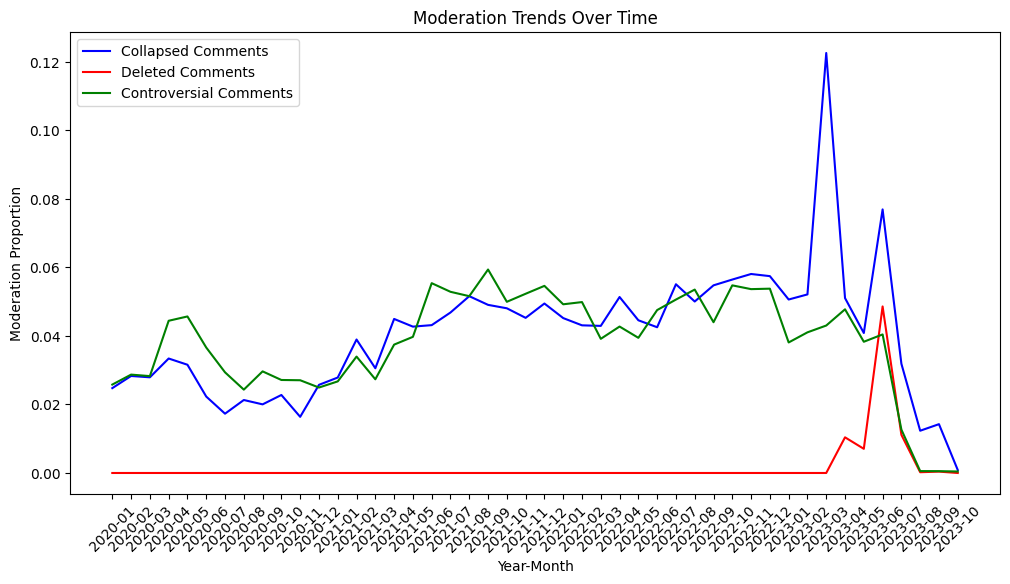

In [140]:
# Convert timestamp to datetime
reddit_df['timestamp'] = pd.to_datetime(reddit_df['timestamp'], errors='coerce')

# Group by year and month to track moderation actions over time
reddit_df['year_month'] = reddit_df['timestamp'].dt.to_period('M')

collapsed_trends = reddit_df.groupby(['year_month'])['is_collapsed'].mean()
deleted_trends = reddit_df.groupby(['year_month'])['is_deleted'].mean()
controversial_trends = reddit_df.groupby(['year_month'])['is_controversial'].mean()

# Plot trends over time
plt.figure(figsize=(12, 6))
plt.plot(collapsed_trends.index.astype(str), collapsed_trends.values, label='Collapsed Comments', color='blue')
plt.plot(deleted_trends.index.astype(str), deleted_trends.values, label='Deleted Comments', color='red')
plt.plot(controversial_trends.index.astype(str), controversial_trends.values, label='Controversial Comments', color='green')

plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Moderation Proportion')
plt.title('Moderation Trends Over Time')
plt.legend()
plt.show()

#### We observed a peak in collapsed comments in March 2023 but no corresponding increase in deleted comments. By looking deeper into the subreddits where these collapses occurred and analyzing the content of these comments, we may identify the events or discussions that drove this moderation spike

In [141]:
# Filter collapsed comments in March 2023 (peak period)
march_2023_collapsed = reddit_df[(reddit_df['timestamp'].dt.to_period('M') == '2023-03') & (reddit_df['is_collapsed'])]
 
# Check for subreddits with the most collapsed comments
march_2023_collapsed_subreddit = march_2023_collapsed.groupby('subreddit_id').size().sort_values(ascending=False)
print("Subreddits with the most collapsed comments in March 2023:")
print(march_2023_collapsed_subreddit.head(10))

# Investigate if specific subreddits are driving the March peak
march_2023_sample = march_2023_collapsed[['moderation', 'text']].sample(10)
print("Sample of collapsed comments in March 2023:")
print(march_2023_sample)

Subreddits with the most collapsed comments in March 2023:
subreddit_id
t5_2qh8c    727
t5_xnx04     62
dtype: int64
Sample of collapsed comments in March 2023:
                                                                                                 moderation  \
259284  {'controversiality': 0, 'collapsed_reason_code': None, 'collapsed': True, 'collapsed_reason': None}   
287783  {'controversiality': 0, 'collapsed_reason_code': None, 'collapsed': True, 'collapsed_reason': None}   
384728  {'controversiality': 0, 'collapsed_reason_code': None, 'collapsed': True, 'collapsed_reason': None}   
275209  {'controversiality': 0, 'collapsed_reason_code': None, 'collapsed': True, 'collapsed_reason': None}   
276177  {'controversiality': 0, 'collapsed_reason_code': None, 'collapsed': True, 'collapsed_reason': None}   
376795  {'controversiality': 0, 'collapsed_reason_code': None, 'collapsed': True, 'collapsed_reason': None}   
342549  {'controversiality': 0, 'collapsed_reason_code': None,

### VISUALISATION 2: MODERATION ACROSS SUBREDDITS

#### Moderation by Subreddit

##### We analyze moderation actions across different subreddits using a stacked bar chart. This gives us insight into which subreddits experience more collapses, deletions, or other moderation actions.

Subreddits with highest proportion of collapsed comments:
              is_collapsed  is_deleted  is_low_score  is_controversial
subreddit_id                                                          
t5_2qh8c          0.040866    0.001616      0.019938          0.038697
t5_xnx04          0.031322    0.000000      0.031099          0.043421
t5_70s6ew         0.001975    0.000000      0.001975          0.006173


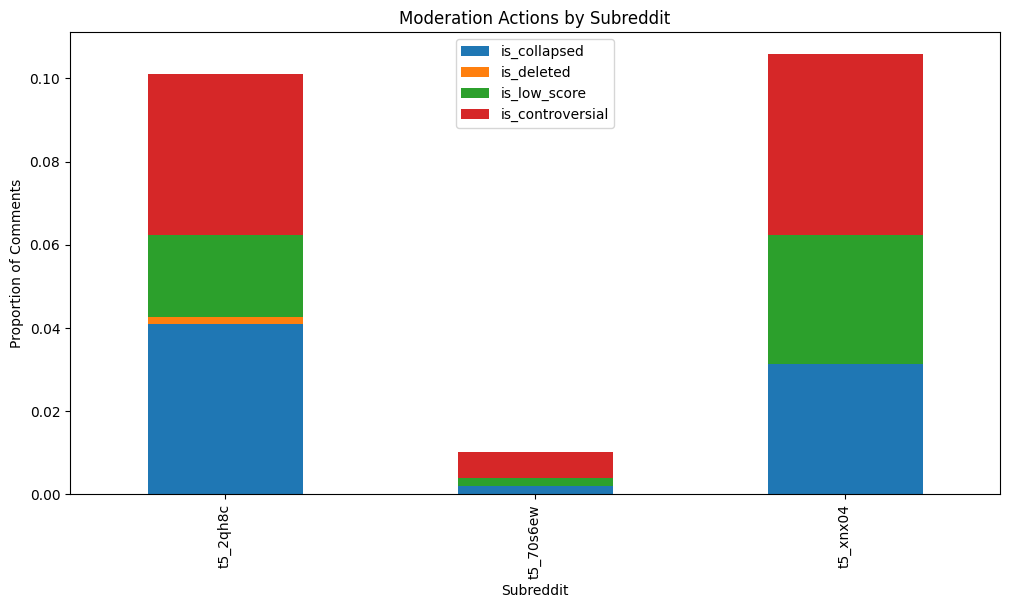

In [142]:
# Group by subreddit to calculate proportions of moderation actions
moderation_by_subreddit = reddit_df.groupby('subreddit_id')[['is_collapsed', 'is_deleted', 'is_low_score', 'is_controversial']].mean()

# Sort subreddits by collapsed comments
collapsed_subreddit_trend = moderation_by_subreddit.sort_values(by='is_collapsed', ascending=False)

# Show top 10 subreddits with the most collapsed comments
print("Subreddits with highest proportion of collapsed comments:")
print(collapsed_subreddit_trend.head(10))

# Plot as a stacked bar chart
ax = moderation_by_subreddit.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.xlabel('Subreddit')
plt.ylabel('Proportion of Comments')
plt.title('Moderation Actions by Subreddit')
plt.show()

### Investigating Specific Moderation Patterns

#### Collapsed Comments with No Reason Code

##### We look into comments that are collapsed but lack a collapsed_reason_code, as this may reveal gaps in moderation logic or data recording.

<Axes: title={'center': 'Collapsed Comments with No Reason Over Time'}, xlabel='timestamp'>

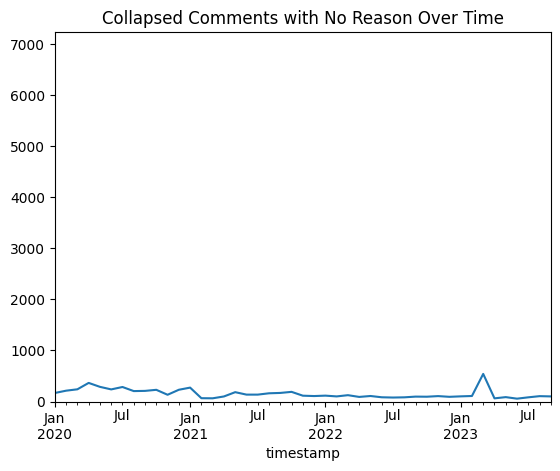

In [143]:
# Filter collapsed comments with no reason code
collapsed_no_reason_code_df = reddit_df[(reddit_df['is_collapsed']) & (reddit_df['moderation'].apply(lambda x: x.get('collapsed_reason_code') is None))]

# Check which subreddits or time periods are associated with these
collapsed_no_reason_code_df.groupby('subreddit_id').size().plot(kind='bar', title='Collapsed Comments with No Reason by Subreddit')

# or do a time-series analysis
collapsed_no_reason_code_df.loc[:, 'timestamp'] = pd.to_datetime(collapsed_no_reason_code_df['timestamp'])
collapsed_no_reason_code_df.set_index('timestamp').resample('M').size().plot(title='Collapsed Comments with No Reason Over Time')

#### Controversial and Reported Comments

##### We also investigate controversial and reported comments to see how these factors interact with collapses or deletions. Understanding this relationship can be critical when recommending moderation improvements.

Controversial and collapsed comments: 1377
Controversial and deleted comments: 23
Reported and collapsed comments: 0
Reported and deleted comments: 0
Empty DataFrame
Columns: [moderation, text]
Index: []


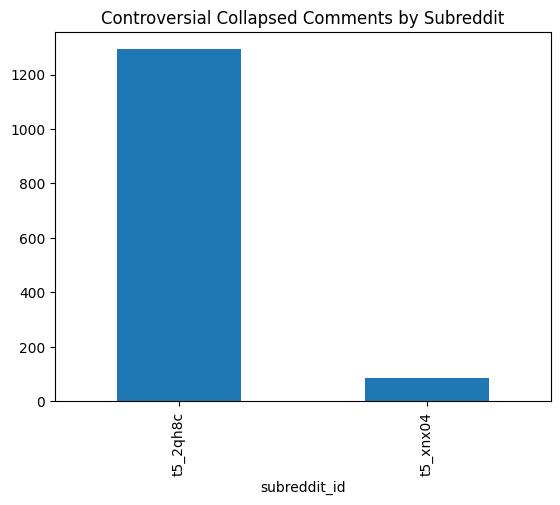

In [144]:
# Find how many controversial comments are collapsed or deleted
controversial_collapsed = reddit_df[(reddit_df['is_controversial']) & (reddit_df['is_collapsed'])]
controversial_deleted = reddit_df[(reddit_df['is_controversial']) & (reddit_df['is_deleted'])]

print(f"Controversial and collapsed comments: {len(controversial_collapsed)}")
print(f"Controversial and deleted comments: {len(controversial_deleted)}")
 
# Explore subreddits for controversial collapsed comments
controversial_collapsed_subreddit = reddit_df[(reddit_df['is_controversial']) & (reddit_df['is_collapsed'])].groupby('subreddit_id').size()

# Plot this distribution
controversial_collapsed_subreddit.plot(kind='bar', title='Controversial Collapsed Comments by Subreddit')

# Filter comments with at least 1 report
reported_comments = reddit_df[reddit_df['moderation'].apply(lambda x: x.get('num_reports', 0) > 0)]

# Check if reported comments are collapsed or deleted
reported_collapsed = reported_comments[reported_comments['is_collapsed']]
reported_deleted = reported_comments[reported_comments['is_deleted']]

print(f"Reported and collapsed comments: {len(reported_collapsed)}")
print(f"Reported and deleted comments: {len(reported_deleted)}")

# Filter for comments with num_reports > 0 and see why no action is being taken
reported_but_no_action_df = reddit_df[(reddit_df['moderation'].apply(lambda x: x.get('num_reports', 0) > 0)) & (~reddit_df['is_collapsed']) & (~reddit_df['is_deleted'])]

# Explore the moderation and text of these comments
print(reported_but_no_action_df[['moderation', 'text']].head(10))

### CONCLUSION AND NEXT STEPS

#### Through this analysis, we explored Reddit's moderation actions, focusing on collapsed, deleted, and controversial comments. We found that many collapsed comments lack a `collapsed_reason_code`, prompting further exploration into the reasons for these actions. Additionally, we observed moderation spikes (e.g., in March 2023), which may be tied to specific discussions or events.

``````
- Why are certain comments collapsed but not deleted? Do they contain sensitive topics that the community finds objectionable but don’t necessarily violate rules?

- What topics drive spikes in moderation? This could help pinpoint community issues or external events that trigger stricter enforcement of guidelines.

- Do controversial comments correlate with any particular subreddits? Understanding where controversial discussions are happening can inform future moderation strategies.